In [1]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEMultiInvProblem, SEMultiSurvey
from simpegEMIP.StretchedExponential import SEInvProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegEM1D import DigFilter
%matplotlib inline
def ColeColeSeigel(f, sigmaInf, eta, tau, c):
    w = 2*np.pi*f
    return sigmaInf*(1 - eta/(1 + (1j*w*tau)**c))

time = np.logspace(-4, np.log10(2.), 51)

In [8]:
def fit_with_se(eta0, tau0, c0):
    wt, tbase, omega_int = DigFilter.setFrequency(time)
    frequency = omega_int / (2*np.pi)
    siginf = 1.
    sigma = ColeColeSeigel(frequency, siginf, eta0, tau0, c0)
    sigTCole, _ = DigFilter.transFilt(sigma, wt, tbase, omega_int, time, tol=1e-12)    
    
    wires = Maps.Wires(('eta', 1), ('tau', 1), ('c', 1))
    taumap = Maps.ExpMap(nP=1)*wires.tau
    etamap = Maps.ExpMap(nP=1)*wires.eta
    cmap = Maps.ExpMap(nP=1)*wires.c
    
    survey = SEMultiSurvey(time=time, locs=np.r_[0, 0, 0], n_pulse=0)
#     survey = SESurvey()
    dtrue = -sigTCole
    survey.dobs = dtrue
    m1D = Mesh.TensorMesh([np.ones(3)])
    prob = SEMultiInvProblem(m1D, etaMap = etamap, tauMap = taumap, cMap=cmap)
#     prob = SEInvProblem(m1D, etaMap = etamap, tauMap = taumap, cMap=cmap, time=time)
    prob.pair(survey)
    m0 = np.log(np.r_[eta0, tau0, c0])
    perc = 0.02
    dmisfitpeta = DataMisfit.l2_DataMisfit(survey)
    dmisfitpeta.W = 1/(abs(survey.dobs)*perc)
    reg = Regularization.Tikhonov(m1D)

    opt = Optimization.ProjectedGNCG(maxIter = 10)
    invProb = InvProblem.BaseInvProblem(dmisfitpeta, reg, opt)
    # Create an inversion object
    target = Directives.TargetMisfit()
    betaSch = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
    opt.upper = np.log(np.r_[1., 10., 1.])
    opt.lower = np.log(np.r_[1e-5, 0.001, 1e-2])
    
    invProb.beta=0.
    inv = Inversion.BaseInversion(invProb, directiveList=[target])
    reg.mref = 0.*m0
    prob.counter = opt.counter = Utils.Counter()
    opt.LSshorten = 0.5
    opt.remember('xc')
    opt.tolX = 1e-20
    opt.tolF = 1e-20
    opt.tolG = 1e-20
    opt.eps = 1e-20
    # opt.lower = 0.
    mopt = inv.run(m0)   
    return np.exp(mopt), survey.dobs, invProb.dpred

In [9]:
eta0, tau0, c0 = 0.1, 5., 0.3
eta1, tau1, c1 = 0.1, 5., 0.5
eta2, tau2, c2 = 0.1, 5., 0.7
eta3, tau3, c3 = 0.1, 0.5, 0.3
eta4, tau4, c4 = 0.1, 0.5, 0.5
eta5, tau5, c5 = 0.1, 0.5, 0.7

mopt0, dobs0, dpred0=fit_with_se(eta0, tau0, c0)
mopt1, dobs1, dpred1=fit_with_se(eta1, tau1, c1)
mopt2, dobs2, dpred2=fit_with_se(eta2, tau2, c2)
mopt3, dobs3, dpred3=fit_with_se(eta3, tau3, c3)
mopt4, dobs4, dpred4=fit_with_se(eta4, tau4, c4)
mopt5, dobs5, dpred5=fit_with_se(eta5, tau5, c5)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  6.59e+01  1.16e+01  6.59e+01    2.69e+00      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 6.6940e-19
0 : |xc-x_last| = 6.6149e-01 <= tolX*(1+|x0|) = 4.0564e-20
0 : |proj(x-g)-x|    = 2.6774e+00 <= tolG          = 1.0000e-20
0 : |proj(x-g)-x|    = 2.6774e+00 <= 1e3*eps       = 1.0000e-17
0 : maxIter   =      10    <= iter          =      1
------------------------- DONE! -------------------------
SimPEG.DataMisfit.l2_Dat

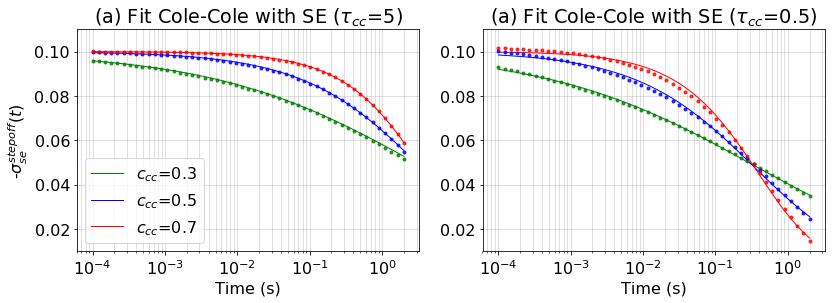

In [25]:
import matplotlib 
matplotlib.rcParams["font.size"] = 16

nskip=1
fig = plt.figure(figsize=(12, 4.5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.plot(time, dobs0, 'g',lw=1)
ax1.plot(time, dobs1, 'b',lw=1)
ax1.plot(time, dobs2, 'r',lw=1)
ax1.legend(("$c_{cc}$=0.3", "$c_{cc}$=0.5", "$c_{cc}$=0.7"))
ax1.plot(time, dpred0, 'g.', alpha = 0.8)
ax1.plot(time, dpred1, 'b.', alpha = 0.8)
ax1.plot(time, dpred2, 'r.', alpha = 0.8)
ax1.set_ylabel("-$\sigma^{stepoff}_{se}(t)$")

ax2.plot(time, dobs3, 'g',lw=1)
ax2.plot(time, dobs4, 'b',lw=1)
ax2.plot(time, dobs5, 'r',lw=1)
ax2.plot(time, dpred3, 'g.', alpha = 0.8)
ax2.plot(time, dpred4, 'b.', alpha = 0.8)
ax2.plot(time, dpred5, 'r.', alpha = 0.8)

for ax in [ax1, ax2]:    
    ax.set_xlabel("Time (s)")
    ax.grid(which='both', alpha=0.5)
    ax.set_ylim(1e-2, 1.1e-1)
    ax.set_xscale('log')
    ax.set_yscale('linear')
ax1.set_title("(a) Fit Cole-Cole with SE ($\\tau_{cc}$=5)")
ax2.set_title("(a) Fit Cole-Cole with SE ($\\tau_{cc}$=0.5)")
plt.tight_layout()
figdir = '/Users/sgkang/Dropbox/spectral_ip_paper/figures/'
fig.savefig(figdir+'fit_colecole_se', dpi=200)

In [26]:
print (("True      eta, tau and c = %.e, %.e and %3.1f")%(eta0, tau0, c0))
print (("Estimated eta, tau and c = %.e, %.e and %3.1f")%(mopt0[0], mopt0[1], mopt0[2]))
print (("True      eta, tau and c = %.e, %.e and %3.1f")%(eta1, tau1, c1))
print (("Estimated eta, tau and c = %.e, %.e and %3.1f")%(mopt1[0], mopt1[1], mopt1[2]))
print (("True      eta, tau and c = %.e, %.e and %3.1f")%(eta2, tau2, c2))
print (("Estimated eta, tau and c = %.e, %.e and %3.1f")%(mopt2[0], mopt2[1], mopt2[2]))

True      eta, tau and c = 1e-01, 5e+00 and 0.3
Estimated eta, tau and c = 1e-01, 9e+00 and 0.2
True      eta, tau and c = 1e-01, 5e+00 and 0.5
Estimated eta, tau and c = 1e-01, 6e+00 and 0.4
True      eta, tau and c = 1e-01, 5e+00 and 0.7
Estimated eta, tau and c = 1e-01, 5e+00 and 0.7


In [27]:
print (("True      eta, tau and c = %.e, %.e and %3.1f")%(eta3, tau3, c3))
print (("Estimated eta, tau and c = %.e, %.e and %3.1f")%(mopt3[0], mopt3[1], mopt3[2]))
print (("True      eta, tau and c = %.e, %.e and %3.1f")%(eta4, tau4, c4))
print (("Estimated eta, tau and c = %.e, %.e and %3.1f")%(mopt4[0], mopt4[1], mopt4[2]))
print (("True      eta, tau and c = %.e, %.e and %3.1f")%(eta5, tau5, c5))
print (("Estimated eta, tau and c = %.e, %.e and %3.1f")%(mopt5[0], mopt5[1], mopt5[2]))

True      eta, tau and c = 1e-01, 5e-01 and 0.3
Estimated eta, tau and c = 1e-01, 1e+00 and 0.2
True      eta, tau and c = 1e-01, 5e-01 and 0.5
Estimated eta, tau and c = 1e-01, 7e-01 and 0.4
True      eta, tau and c = 1e-01, 5e-01 and 0.7
Estimated eta, tau and c = 1e-01, 6e-01 and 0.5
